In [1]:
import requests
import numpy as np
import pandas as pd

import json
import time
from datetime import datetime, timedelta
import sgp4
from sgp4.api import Satrec, WGS72
from sgp4.conveniences import jday
from sgp4.ext import invjday

In [2]:
def get_tle():
    # Space-Track API의 URL
    url = "https://www.space-track.org/ajaxauth/login"

    # 요청에 필요한 인증 정보
    payload = {"identity": 'asas4539@hanyang.ac.kr', "password": 'onsaemiro1729!!'}

    # Session 객체 생성
    session = requests.Session()

    # 로그인 요청
    response = session.post(url, data=payload)

    if response.status_code != 200:
        print("로그인에 실패했습니다.")
        return None

    # TLE 요청
    response = session.get(
        f"https://www.space-track.org/basicspacedata/query/class/tle/NORAD_CAT_ID/58400/EPOCH/2023-11-22--2024-07-04/orderby/EPOCH%20asc/format/3le/emptyresult/show"
    )#

    return response

In [5]:
response = get_tle()
tle_datas = response.text.split('\r\n')

tle_first_lst = []
tle_second_lst = []

for i in range(0, len(tle_datas)-2, 3):
    tle_first_lst.append(tle_datas[i+1])
    tle_second_lst.append(tle_datas[i+2])

tle_df = pd.DataFrame({'first_line':tle_first_lst, 'second_line':tle_second_lst})
tle_df.drop_duplicates(keep='first', inplace=True)
tle_df.reset_index(inplace=True, drop=True)

In [6]:
change_times = []
for i in range(len(tle_df)):
    tle_1, tle_2 = tle_df['first_line'].iloc[i], tle_df['first_line'].iloc[i]
    satellite = Satrec.twoline2rv(tle_1,tle_2)
    jdsatepoch = satellite.jdsatepoch
    jdsatepochfrac = satellite.jdsatepochF
    epochdatetime = invjday(jdsatepoch + jdsatepochfrac)
    change_times.append(epochdatetime)

In [7]:
change_df = pd.DataFrame(change_times)
change_df.columns = ['year', 'month', 'day', 'hour', 'minute', 'second']
change_df['first_line']=tle_df['first_line']
change_df['second_line']=tle_df['second_line']
change_df['time'] = change_df['year'].astype('str') + '-' + change_df['month'].astype('str') + '-' + change_df['day'].astype('str') + ' ' + change_df['hour'].astype('str') + ':' + change_df['minute'].astype('str') + ':' + change_df['second'].astype('int').astype('str')
change_df['time'] = pd.to_datetime(change_df['time'])

In [47]:
epoch = datetime(2023,11, 22, 0, 15, 0)
all_info = []

earth_radius = 6378.137
rad2deg = 180.0 / 3.141592653589793

while epoch < datetime(2024, 7, 4, 0, 0, 0):
    # print(epoch)
    year = epoch.year
    month = epoch.month
    date = epoch.day
    hour = epoch.hour
    minute = epoch.minute

    now_time = str(year) +'-' + str(month) + '-' + str(date) + ' ' + str(hour) + ':' + str(minute) + ':' + str(0)
    temp = change_df[change_df['time'] <= pd.to_datetime(now_time)].copy()

    jd, fr =jday(year, month, date, hour, minute, 0)

    tle1,tle2 = temp.iloc[-1]['first_line'], temp.iloc[-1]['second_line']
    satellite = Satrec.twoline2rv(tle1, tle2)

    e, position, velocity = satellite.sgp4(jd, fr)

    all_info.append([len(temp), tle1, tle2,
                     year, month, date, hour, minute, 
                     position[0], position[1], position[2], velocity[0], velocity[1], velocity[2],
                     (position[0]**2 + position[1]**2 + position[2]**2)**0.5- earth_radius, (velocity[0]**2 + velocity[1]**2 + velocity[2]**2)**0.5,
                     satellite.alta * earth_radius , satellite.altp * earth_radius,
                     satellite.inclo*rad2deg, satellite.ecco, satellite.nodeo])

    epoch += timedelta(minutes=1)

In [49]:
info_df = pd.DataFrame(all_info)
info_df.columns = ['change', 'tle1','tle2',
                    'year', 'month', 'day', 'hour', 'minute', 
                   'x', 'y', 'z', 'vx', 'vy', 'vz',
                    'altitude', 'velocity', 
                    'apogee', 'perigee', 
                    'inclination', 'eccentricity', 'raan']
info_df['change'] = (info_df['change'].diff().fillna(1)>=1) * 1
info_wo_tle_df = info_df.drop(['tle1', 'tle2'], axis=1).copy()

In [4]:
# info_wo_tle_df.to_csv('File/info_wo_tle_df.csv')

In [18]:
info_wo_tle_df= pd.read_csv('File/info_wo_tle_df.csv')

In [26]:
df_1=info_wo_tle_df[['year', 'month', 'day', 'hour', 'raan']]

In [27]:
# 연, 월, 일, 시를 하나로 합쳐 datetime 형식으로 변환
df_1.loc[:, 'datetime'] = pd.to_datetime(df_1[['year', 'month', 'day', 'hour']])

# datetime 열을 인덱스로 설정
df_1.set_index('datetime', inplace=True)

# 필요 없는 열 제거 (옵션)
df_1.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)

df_1=df_1.resample('h').mean()

C:\Users\asas4\AppData\Local\Temp\ipykernel_7988\1948842781.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1.loc[:, 'datetime'] = pd.to_datetime(df_1[['year', 'month', 'day', 'hour']])
C:\Users\asas4\AppData\Local\Temp\ipykernel_7988\1948842781.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)


In [142]:
df_2= df_1.rolling(window=120).mean().dropna()

In [28]:
df_2=df_1

In [29]:
window = 500
ol_idxs = []
for i in range(window,5400 - window,1):
    window_diff = df_2[i-window : i]
    z_norm = ((window_diff - window_diff.mean())/window_diff.std())
    final_val = float(z_norm.values[-1])
    
    if np.abs(final_val) > 3:
        ol_idxs.append(i)

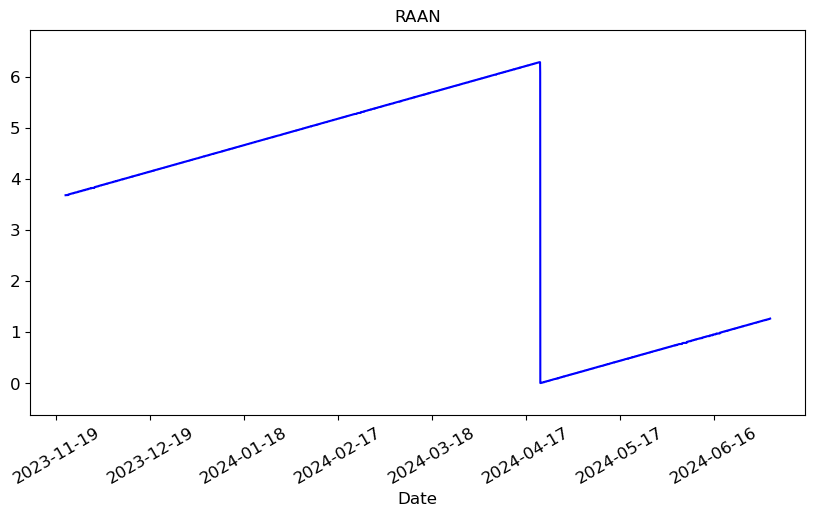

In [31]:
from utils.Plot import *
draw_graph(df_2, 'RAAN', '', pd.DataFrame(df_2.iloc[ol_idxs].index.date).drop_duplicates().values.tolist(), "blue")

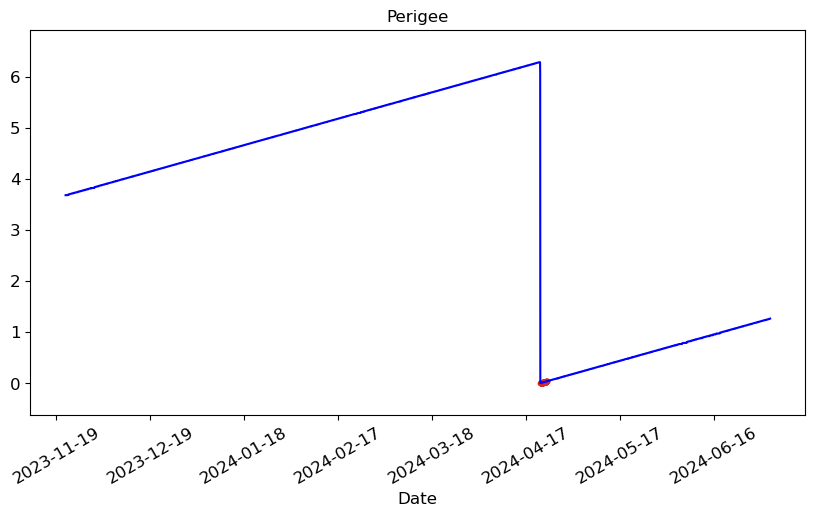

In [32]:
plt.figure(figsize=(10, 5))

plt.plot(df_2.index, df_2.values, color='Blue')
plt.scatter(df_2.iloc[ol_idxs].index, df_2.iloc[ol_idxs], c='tab:red',s=10)

set_plot_params('Perigee', '')
ylim_min, ylim_max = calculate_ylim(list(df_2.values))
plt.ylim(ylim_min, ylim_max)
plt.show()